In [32]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("../../src/")
from utils import read_xray
import matplotlib.patches as ptc
from tqdm.notebook import tqdm

In [47]:
import warnings
warnings.filterwarnings('ignore')

In [82]:
path2labels_train = "/scratch/scratch6/akansh12/DeepEXrays/physionet.org/files/vindr-cxr/1.0.0/annotations/annotations_train.csv"
bbox_train = pd.read_csv(path2labels_train)
path2labels_test = "/scratch/scratch6/akansh12/DeepEXrays/physionet.org/files/vindr-cxr/1.0.0/annotations/annotations_test.csv"
bbox_test = pd.read_csv(path2labels_test)

labels = ['Aortic enlargement', 'Atelectasis','Calcification', 'Cardiomegaly', 'Consolidation','ILD', 'Infiltration','Lung Opacity','Nodule/Mass','Other lesion', 'Pleural effusion', 'Pleural thickening', 'Pneumothorax',
       'Pulmonary fibrosis', 'No finding']
label_idx = list(range(0,len(labels)))
label_dict = dict(zip(labels, label_idx))

#Training Set
#Removing other than 14 classes
for i in tqdm(bbox_train.index):
    try:
        bbox_train.loc[i, 'class_id'] = label_dict[bbox_train.loc[i]['class_name']]
    except:
        bbox_train.drop(i, inplace = True)
bbox_train.set_index('image_id', inplace=True)

#Testing Set
#Removing other than 14 classes
for i in tqdm(bbox_test.index):
    try:
        bbox_test.loc[i, 'class_id'] = label_dict[bbox_test.loc[i]['class_name']]
    except:
        bbox_test.drop(i, inplace = True)
bbox_test.set_index('image_id', inplace=True)

In [89]:
def resize_bbox(img_name, bboxes, h, w, data_type = 'train'):
    img_arr = read_xray(f"/scratch/scratch6/akansh12/DeepEXrays/physionet.org/files/vindr-cxr/1.0.0/{data_type}/{img_name}.dicom")
    x_scale = w/img_arr.shape[1]
    y_scale = h/img_arr.shape[0]
    return bboxes*[x_scale,y_scale,x_scale,y_scale] 

In [54]:
#Training set
# Resizing to 256x256 
for i in tqdm(np.unique(bbox_train.index)):
    transformed_dict = resize_bbox(i,bbox_train.loc[i,['x_min','y_min', 'x_max', 'y_max']].values, 256,256, 'train')
    bbox_train.loc[i, ['x_min','y_min', 'x_max', 'y_max']] = np.array(transformed_dict)

  0%|          | 0/15000 [00:00<?, ?it/s]

In [59]:
bbox_train.to_csv("./bboxes/train_bbox.csv")

In [90]:
#Testing set
# Resizing to 256x256 
for i in tqdm(np.unique(bbox_test.index)):
    transformed_dict = resize_bbox(i,bbox_test.loc[i,['x_min','y_min', 'x_max', 'y_max']].values, 256,256, 'test')
    bbox_test.loc[i, ['x_min','y_min', 'x_max', 'y_max']] = np.array(transformed_dict)

  0%|          | 0/2997 [00:00<?, ?it/s]

In [93]:
bbox_test.to_csv("./bboxes/test_bbox.csv")

In [115]:
cols = ['#e41a1c', '#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#999999', '#000000', '#1b9e77', '#d95f02', '#7570b3', '#e7298a']
def view_with_annot(image_name, train_csv, data_type = 'train'):
    img = Image.open(f"/scratch/scratch6/akansh12/DeepEXrays/data/data_256/{data_type}/{image_name}.png")
    fig, ax = plt.subplots(1, figsize = (6,6))
    ax.imshow(img, cmap = 'gray')
    for i in range(0,len(train_csv[train_csv['image_id']==image_name])):
        rect = ptc.Rectangle((train_csv[train_csv['image_id']==image_name].reset_index(drop = True).x_min[i], 
                              train_csv[train_csv['image_id']==image_name].reset_index(drop = True).y_min[i]), 
                             train_csv[train_csv['image_id']==image_name].reset_index(drop = True).x_max[i]-train_csv[train_csv['image_id']==image_name].reset_index(drop = True).x_min[i], 
                             train_csv[train_csv['image_id']==image_name].reset_index(drop = True).y_max[i]-train_csv[train_csv['image_id']==image_name].reset_index(drop = True).y_min[i], 
                             linewidth = 1, edgecolor = '#377eb8', facecolor = 'none')
        ax.add_patch(rect)
        ax.annotate(train_csv[train_csv['image_id']==image_name].reset_index(drop = True).class_name[i],
                    (train_csv[train_csv['image_id']==image_name].reset_index(drop = True).x_min[i], 
                    train_csv[train_csv['image_id']==image_name].reset_index(drop = True).y_min[i] - 24) )

In [119]:
bbox_train.class_id

0        14.0
1        14.0
2        14.0
3        14.0
4        14.0
         ... 
67965    14.0
67966    14.0
67967    14.0
67968    14.0
67969    14.0
Name: class_id, Length: 67970, dtype: float64

### Raw annotations

In [103]:
bbox_train = pd.read_csv("./bboxes/train_bbox.csv")

In [101]:
rnd_train_img = np.random.choice(np.unique(bbox_train.image_id), 4)

In [109]:
bbox_train.set_index('image_id').loc[rnd_train_img[3]]

,rad_id,class_name,x_min,y_min,x_max,y_max,class_id
image_id,,,,,,,
db7da50ba329b52f6779db53689c289f,R10,Aortic enlargement,124.752091,72.177801,155.817428,118.558298,0.0
db7da50ba329b52f6779db53689c289f,R8,Aortic enlargement,124.559505,73.797676,154.508273,106.644107,0.0
db7da50ba329b52f6779db53689c289f,R9,Aortic enlargement,120.504250,73.224338,155.172107,107.874980,0.0


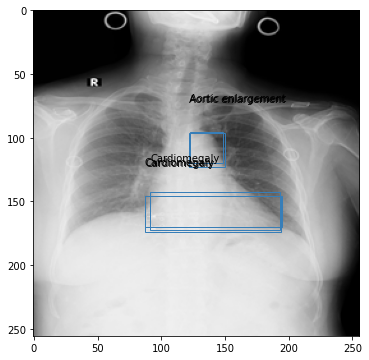

In [116]:
view_with_annot(rnd_train_img[0], bbox_train)

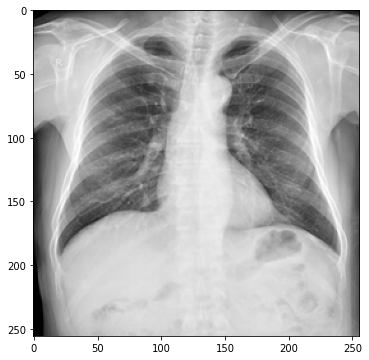

In [117]:
view_with_annot(rnd_train_img[1], bbox_train)

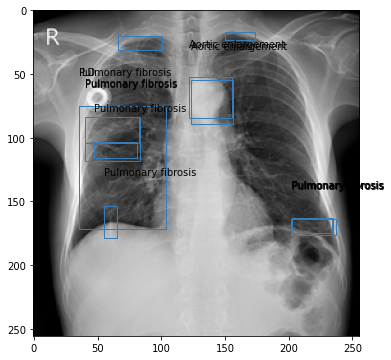

In [118]:
view_with_annot(rnd_train_img[2], bbox_train)